In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.4 MB/s eta 0:00:00


In [3]:

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from scipy.special import boxcox1p
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Chargement des données (Train)

In [4]:


#Charger les données
train =pd.read_csv('/content/drive/MyDrive/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Chargement des données (Test)

In [5]:

test =pd.read_csv('/content/drive/MyDrive/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
train.shape

(1460, 81)

In [7]:
test.shape

(1459, 80)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [10]:
train_ID = train['Id']
test_ID = test['Id']

Variable cible

In [11]:
train['SalePrice'].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


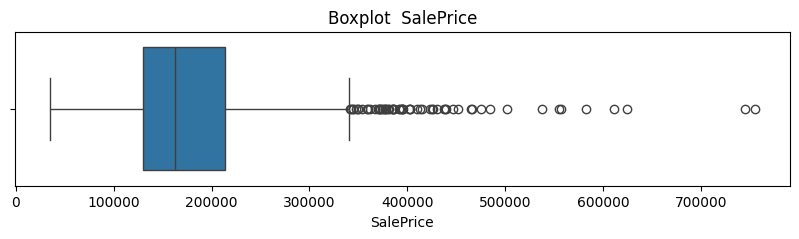

In [12]:

plt.figure(figsize=(10, 2))
sns.boxplot(x=train['SalePrice'])
plt.title('Boxplot  SalePrice')
plt.show()


On remarque qu'il y a 2 outliers  avec des prix supérieurs à 70 000

<Axes: xlabel='SalePrice', ylabel='Density'>

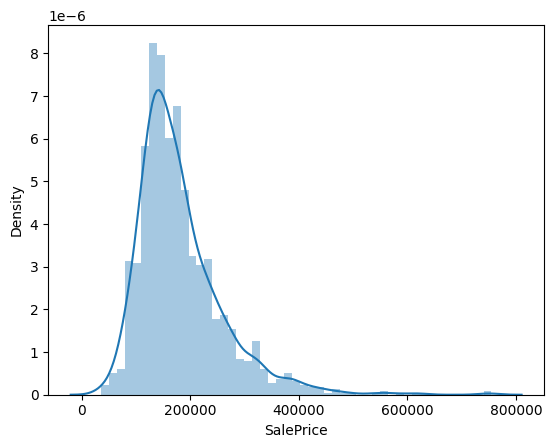

In [13]:
sns.distplot(train['SalePrice'])

cette courbe est asymetrique à droite (positive skew)  
* Majorité des maisons ont un prix autour de 100,000 à 200,000 $. ( Mean= 180921.19 $)
* Présence d’outliers :
Les valeurs très élevées (> 500,000) sont rares mais influentes.

Correlation de chaque  variable avec la variable cible

Les variables les plus corrélées avec SalePrice :
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr  

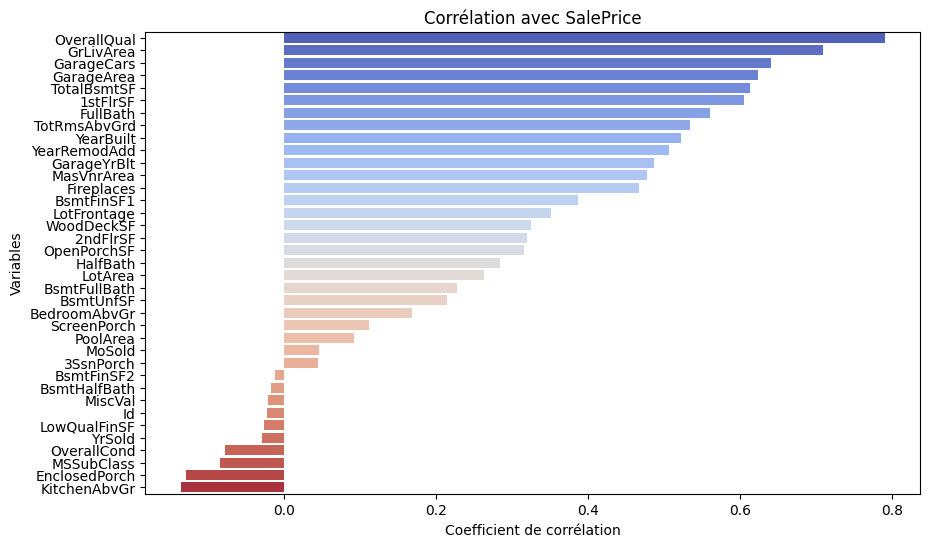

In [14]:
# Calcul de la corrélation entre SalePrice et les autres variables numériques
correlation_matrix = train.corr(numeric_only=True)

# Trie des variables les plus corrélées avec SalePrice (hors elle-même)
correlated_features = correlation_matrix['SalePrice'].sort_values(ascending=False)[1:]

# Affichage des  variables les plus corrélées
print("Les variables les plus corrélées avec SalePrice :")
print(correlated_features)


plt.figure(figsize=(10, 6))
sns.barplot(x=correlated_features.values, y=correlated_features.index, palette="coolwarm")
plt.title("Corrélation avec SalePrice")
plt.xlabel("Coefficient de corrélation")
plt.ylabel("Variables")
plt.show()

Afin de rendre SalePrice plus normal, nous utilisons la transformation logarithmique log1p.

* Réduire l'influence des outliers (prix très élevés),

* Rendre la distribution plus symétrique,

* Améliorer la performance des modèles.

In [15]:

y = np.log1p(train['SalePrice'])

Text(0.5, 1.0, 'density of SalePrice after Log transformation')

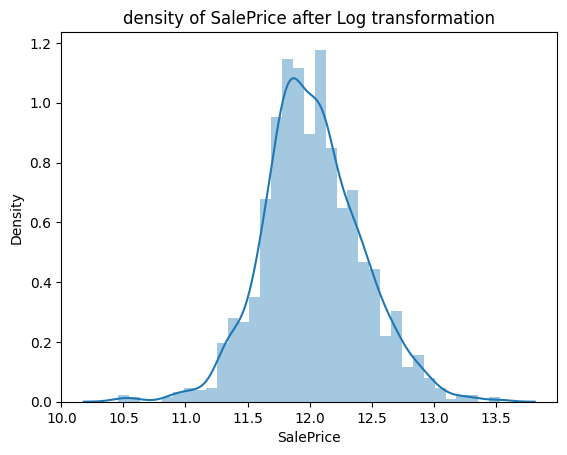

In [16]:
sns.distplot(y)
plt.title("density of SalePrice after Log transformation")

Les Valeurs Manquantes

In [17]:
train.isnull().sum()


,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


Les valeurs manquantes en Pourcentages


In [18]:
# Pourcentage de valeurs nulles par colonne
null_percent = train.isnull().mean() * 100

# Colonnes avec plus de 60% de valeurs nulles
cols_above  = null_percent[null_percent >=10]

# Affichage
print(cols_above )

LotFrontage    17.739726
Alley          93.767123
MasVnrType     59.726027
FireplaceQu    47.260274
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64


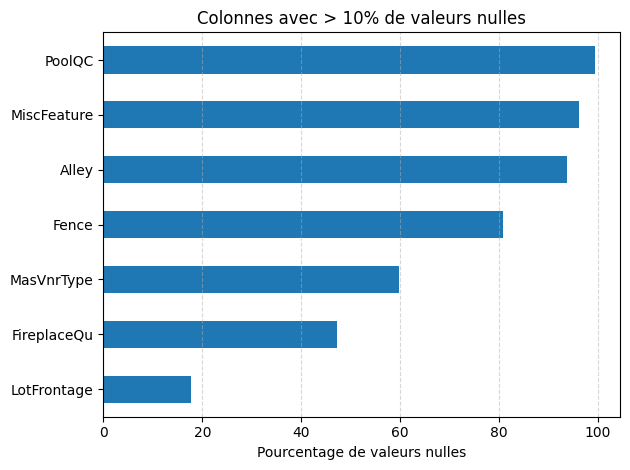

In [19]:

# Bar plot
cols_above.sort_values().plot(kind='barh')
plt.xlabel("Pourcentage de valeurs nulles")
plt.title("Colonnes avec > 10% de valeurs nulles")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Suppression des Variables inutile pour le modèle  :
* Supprimer 'Id' et 'SalePrice' pour le train dataset
* Supprimer 'Id' pour le test dataset

In [20]:
train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

Fusionner les ensembles de données d'entraînement et de test pour un traitement global et cohérent.

In [21]:
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)


**Pour les Colonnes Catgorielles** : Remplacer  les valeurs manquantes (NaN) par la chaîne de caractères 'None'

In [22]:
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']:
    all_data[col] = all_data[col].fillna('None')



 **Pour les colonnes numérique** : Remplacer les valeurs manquantes par 0

In [23]:
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']:
    all_data[col] = all_data[col].fillna(0)

Remplit les valeurs manquantes de LotFrontage avec la médiane du quartier (Neighborhood) correspondant, ce qui permet une imputation plus cohérente et contextuelle.
*  On respecte mieux la distribution des données, ce qui peut améliorer les performances du modèle.

In [24]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


**Feature Engineering**

In [25]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBathrooms'] = (all_data['FullBath'] + 0.5 * all_data['HalfBath'] +
                               all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'])
all_data['IsRemodeled'] = (all_data['YearBuilt'] != all_data['YearRemodAdd']).astype(int)
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']


Correction Skew

On récupère toutes les colonnes numériques du jeu de données all_data.



In [26]:

numeric_feats = all_data.select_dtypes(include=['number']).columns


 Pour chaque variable numérique, on applique la fonction skew() (asymétrie). On enlève les NaN avec .dropna().

In [27]:
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))


On garde seulement les colonnes dont le skew est supérieur à 0.75 (seuil typique pour détecter une asymétrie significative).

In [28]:
skewed_feats = skewed_feats[skewed_feats > 0.75].index


on applique une transformation Box-Cox modifiée : boxcox1p(x, λ)
avec lambda hyperparametre qui controle l'intensité de la transformation

In [29]:
for feat in skewed_feats:
  all_data[feat] = boxcox1p(all_data[feat], 0.15)


#  One-hot encoding


applique  la transformation One-Hot Encoding à toutes les colonnes catégorielles de all_data.



In [30]:
all_data = pd.get_dummies(all_data)


# Séparation du train et test

In [31]:
X = all_data[:len(train)]
X_test = all_data[len(train):]

# Normalisation robuste

Contrairement à StandardScaler (qui utilise la moyenne et l’écart-type), RobustScaler se base sur :

* La médiane (au lieu de la moyenne)

* L’écart interquartile (IQR) : c’est-à-dire Q3 - Q1

* X_scaled = (X - median) / IQR
* Robuste face aux outliers

In [32]:

scaler = RobustScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Cross Validation


* mesurer les performances du modèle en le testant sur n_splits (5):
➜ à chaque itération, 4 folds sont utilisés pour entraîner, 1 pour tester

* shuffle=True : Mélange les données avant de les diviser
➜ évite que les données soient triées (par date, prix, etc.)

* random_state=42 : Assure que le mélange est reproductible
➜  toujours les mêmes splits



In [33]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)


Cette fonction retourne la RMSE moyenne en validation croisée, pour évaluer la précision d’un modèle de régression.

In [34]:
def rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))


# Modeles

Le stacking est une technique d'ensemble avancée qui combine plusieurs modèles  pour améliorer les performances globales.

J'ai utilisé 2 modeles lineaires  (Lasso et Ridge )
et 3 modèles de boosting : (Xgboost , lightgbm , catboosting)
 Cette méthode :
* Combine les forces de plusieurs modèles

* Réduit le biais et la variance

* Très utile quand les modèles de base sont complémentaires



In [42]:

ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.0005)
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, subsample=0.7, colsample_bytree=0.7, random_state=42,force_col_wise=True)
lgb = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=32, random_state=42)
cat = CatBoostRegressor(verbose=0, iterations=1000, learning_rate=0.05, depth=6, random_state=42)


# Stacking

On crée un modèle d’ensemble (stacking) avec Ridge, Lasso, XGBoost, LightGBM, et CatBoost comme base learners, et un Lasso final qui combine leurs prédictions et les features originales pour améliorer les performances.

In [36]:

stack = StackingRegressor(
    estimators=[('ridge', ridge), ('lasso', lasso), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
    final_estimator=Lasso(alpha=0.0005),
    passthrough=True
)

# Score

Cette boucle affiche les performances (RMSE moyenne ± écart-type) de plusieurs modèles de régression évalués par validation croisée.

In [37]:
for model, name in zip([ridge, lasso, xgb, lgb, cat, stack], ['Ridge', 'Lasso', 'XGB', 'LGBM', 'CatBoost', 'Stacking']):
    score = rmse_cv(model)
    print(f'{name} CV RMSE: {score.mean():.5f} ± {score.std():.5f}')


Ridge CV RMSE: 0.13142 ± 0.02312
Lasso CV RMSE: 0.12664 ± 0.02412
XGB CV RMSE: 0.12590 ± 0.01613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3583
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 197
[LightGBM] [Info] Start training from score 12.030658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3582
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 200
[LightGBM] [Info] Start training from score 12.016898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0

# Fit final et Prédiction

 C’est l’entraînement final du modèle, après toutes les validations croisées.

In [43]:

stack.fit(X, y)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3856
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 206
[LightGBM] [Info] Start training from score 12.024057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3565
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 200
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

StackingRegressor(estimators=[('ridge', Ridge(alpha=10)),
                              ('lasso', Lasso(alpha=0.0005)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            import...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.05,
                                             n_estimators=1000, num_leaves=32,
                                             random_state=42)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x78dfd9f5e1d0>)],
                  final_estimator=Lasso(alpha=0.0005), passthrough=True)

* Prédit les prix sur les données de test avec le modèle entraîné :

* stack.predict(X_test) donne la prédiction log-transformée .

* np.expm1() inverse la transformation logarithmique, donc :

* SalePrice pr
e
ˊ
dite
=
exp
⁡
(
log(SalePrice)
)
−
1
SalePrice pr
e
ˊ
 dite=exp(log(SalePrice))−1
*  Ce qui reconvertit les prédictions dans l’échelle réelle des prix .

In [47]:
final_preds = np.expm1(stack.predict(X_test))




# Soumission

In [49]:
# Soumission

submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': final_preds
})
submission.to_csv('submission_stack.csv', index=False)


In [50]:
from google.colab import files
files.download('submission_stack.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>